# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [1]:
# helper functions
import os
import skimage.io
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [2]:
data_base_path = os.path.join(os.curdir, 'project-data')
images_folder = 'images/'
annotations_folder = 'annotations/'

train_folder = 'train/'
test_folder = 'test/'
validation_folder = 'validation/'


image_train_path = os.path.join(data_base_path, images_folder+train_folder)
image_test_path = os.path.join(data_base_path, images_folder+test_folder)
image_validation_path = os.path.join(data_base_path, images_folder+validation_folder)

annotation_train_path = os.path.join(data_base_path, annotations_folder+train_folder)
annotation_test_path = os.path.join(data_base_path, annotations_folder+test_folder)
annotation_validation_path = os.path.join(data_base_path, annotations_folder+validation_folder)


with open(data_base_path+'/train.txt') as f:
    names_train = [i.strip('\n') for i in f.readlines()]
    
with open(data_base_path+'/test.txt') as f:
    names_test = [i.strip('\n') for i in f.readlines()]

with open(data_base_path+'/validation.txt') as f:
    names_validation = [i.strip('\n') for i in f.readlines()]

image_train_filenames = [os.path.join(image_train_path, name) + '.jpg' for name in names_train]
image_test_filenames = [os.path.join(image_test_path, name) + '.jpg' for name in names_test]
image_validation_filenames = [os.path.join(image_validation_path, name) + '.jpg' for name in names_validation]

In [3]:
# load annotations and images
annotations_train = [parse_file(os.path.join(annotation_train_path, name) + '.xml') for name in names_train]
annotations_test = [parse_file(os.path.join(annotation_test_path, name) + '.xml') for name in names_test]
annotations_validation = [parse_file(os.path.join(annotation_validation_path, name) + '.xml') for name in names_validation]

image_train = skimage.io.imread_collection(image_train_filenames)
image_test = skimage.io.imread_collection(image_test_filenames)
image_validation = skimage.io.imread_collection(image_validation_filenames)


In [4]:
print('Number of images/annotations in train: ', len(image_train), len(annotations_train))
print('Number of images/annotations in test: ', len(image_test), len(annotations_test))
print('Number of images/annotations in validation: ', len(image_validation), len(annotations_validation))

Number of images/annotations in train:  800 800
Number of images/annotations in test:  50 50
Number of images/annotations in validation:  150 150


## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [1]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [2]:
#Your code

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

### Proposed Methods
I proposed some methods to extract feature from each image patch.

<input type='checkbox'></input> HOG: doesnot work, because the image is very small, and the method of HOG is very sensitive with the noise.

<input type='checkbox'></input> Moment

In [275]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import moments_hu, moments, moments_central, moments_normalized
from sklearn.feature_extraction import image
from sklearn import svm
from skimage.filters import threshold_otsu
from skimage import transform
from skimage.util.shape import view_as_windows
from skimage.morphology import dilation, erosion, opening, closing, square
from scipy.ndimage import morphology
plt.rcParams['figure.figsize'] = [17, 7]
import warnings
warnings.filterwarnings('ignore')

### Proprecessing

In [6]:
def varroa_thresholding(input_image):
    
    # Transforming the image to HSV format to find the mean of lightness of image
    image_hsv = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
    mean_hsv = np.mean(image_hsv[:,:,2])
    
    # Improving the lightness based on the mean lightness of the image (if it is not decent)
    if (mean_hsv <= 110):
        image_hsv[:,:,2] = image_hsv[:,:,2] *1.2
    elif(mean_hsv > 150):
        image_hsv[:,:,2] = image_hsv[:,:,2] *0.8
    
    # Performing an adaptive thresholding on the grayscale version of image
    image_rgb = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    image_grayscale = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
    image_thresholded= ~(cv2.adaptiveThreshold(image_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,3))
    
    # Performing different morphological operations to improve the result
    image_processed = skimage.morphology.remove_small_objects(image_thresholded.astype(bool), min_size=300)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(4), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(5), out=None)
    image_processed = skimage.morphology.binary_erosion(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.binary_dilation(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=230)
    image_processed = skimage.morphology.binary_opening(image_processed, selem = square(6), out=None)
    image_processed = morphology.binary_fill_holes(image_processed).astype(np.uint8)
    
    return image_processed

###### Show images

In [450]:
def varroa_thresholding_1(input_image):
    
    # Transforming the image to HSV format to find the mean of lightness of image
    image_hsv = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
    mean_hsv = np.mean(image_hsv[:,:,2])
    
    # Improving the lightness based on the mean lightness of the image (if it is not decent)
    if (mean_hsv <= 110):
        image_hsv[:,:,2] = image_hsv[:,:,2] *1.2
    elif(mean_hsv > 150):
        image_hsv[:,:,2] = image_hsv[:,:,2] *0.8
    
    # Performing an adaptive thresholding on the grayscale version of image
    image_rgb = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    image_grayscale = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
#     image_grayscale = cv2.equalizeHist(image_grayscale)
#     clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
#     image_grayscale = clahe.apply(image_grayscale)
#     plt.hist(image_grayscale.ravel(),bins=100)
#     plt.show()
#     image_thresholded= ~(cv2.adaptiveThreshold(image_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,3))
    image_thresholded = (image_grayscale < 100)
    image_processed = skimage.morphology.remove_small_objects(image_thresholded.astype(bool), min_size=300)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(4), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(5), out=None)
    image_processed = skimage.morphology.binary_erosion(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.binary_dilation(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=230)
    image_processed = skimage.morphology.binary_opening(image_processed, selem = square(6), out=None)
    image_processed = morphology.binary_fill_holes(image_processed).astype(np.uint8)
    return image_processed

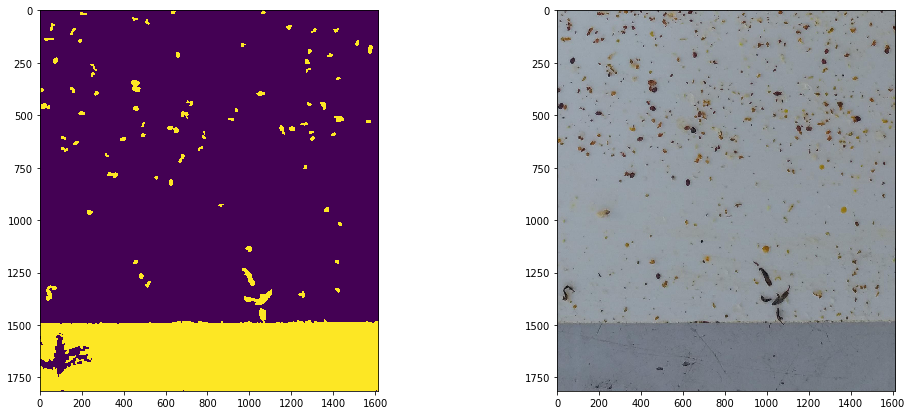

In [451]:
fig, ax = plt.subplots(1,2)
img2 = varroa_thresholding_1(image_test[2])
ax[0].imshow(img2)
ax[1].imshow(image_test[2])

In [443]:
np.shape(img2)

(1814, 1613)

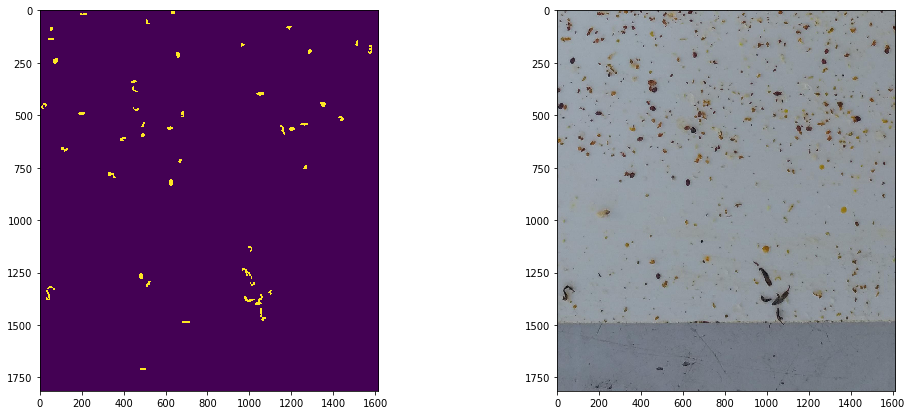

In [436]:
fig, ax = plt.subplots(1,2)
img2 = varroa_thresholding(image_test[2])
ax[0].imshow(img2)
ax[1].imshow(image_test[2])

In [ ]:
brain_im_eqhist= cv2.equalizeHist(brain_im_medfil) 

In [8]:
def plotAnnoOnImg(img, anno):
    fig, ax = plt.subplots(1,2)
    img_process = varroa_thresholding(img)
    for an in anno:
        rect = patches.Rectangle((an['bbox'][0], an['bbox'][1]), an['bbox'][2], an['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
#         ax[0].add_patch(rect)
        ax[1].add_patch(rect)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].imshow(img_process)
    plt.show()

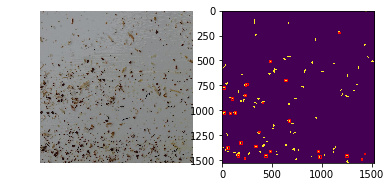

In [9]:
plotAnnoOnImg(image_train[1], annotations_train[1])

##### helper functions

In [194]:
def generateSampleImg(img, anno):
    """
        Get the part of image from the original images and the tags
    """
    annoImg = []
#     [x_1, y_1, w_1, h_2]
    for an in anno:
        x = an['bbox'][0]
        y = an['bbox'][1]
        w = an['bbox'][2]
        h = an['bbox'][3]
        img_select = img[y:y+h, x:x+w]
        moment_select = cv2.moments(img_select)
        img_center = np.array([(2*y + h) // 2, (2*x + w) // 2])
        try:
            moment_center = np.array([y + moment_select['m10'] / moment_select['m00'],
                             x + moment_select['m01'] / moment_select['m00']])
        except:
            continue
        
        diff = np.int16(moment_center - img_center)
        y = np.max([y + diff[1], 0])
        x = np.max([x + diff[0], 0])
        
        img_select_update = img[y:y+h, x:x+w]
        
        annoImg.append(img_select_update)
    return annoImg

In [168]:
# generate the test data
image_test_preprocess = [varroa_thresholding(img) for img in image_test]

In [169]:
image_train_preprocess = [varroa_thresholding(img) for img in image_train]

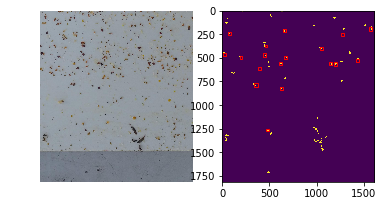

In [25]:
plotAnnoOnImg(image_test[2], annotations_test[2])

In [34]:
def IoUcalc(img):
    U = np.sum(img>0)
    I = np.sum(img==2)
    return I / U

In [231]:
def generateSamples(img, anno, blockSize, stepSize, IoU_thresh):
    """
        Generate the positive and negative samples from an image
    """
    posSamples = []
    negSamples = []
    
    if len(anno) == 0:
        return None, None

    
    imgH, imgW = np.shape(img)
    
    # fill in the anno
    imgTag = np.zeros_like(img)
    for an in anno:
        imgTag[an['bbox'][1]:an['bbox'][1]+an['bbox'][3], an['bbox'][0]:an['bbox'][0]+an['bbox'][2]] = 1
        
    for an in anno:
        y = an['bbox'][0]
        x = an['bbox'][1]
        w = an['bbox'][2]
        h = an['bbox'][3]
        
        xmin = max(x-blockSize, 0)
        ymin = max(y-blockSize, 0)
        xmax = min(x+h+blockSize, imgH)
        ymax = min(y+w+blockSize, imgW)
        
        nx = (xmax-xmin-blockSize) // stepSize
        ny = (ymax-ymin-blockSize) // stepSize
        
        imgTagPart = imgTag[xmin:xmax, ymin:ymax]
        
        for ix in range(nx):
            for iy in range(ny):
                imgWindow = np.zeros_like(imgTagPart)
                imgWindow[ix*stepSize:ix*stepSize+blockSize, iy*stepSize:iy*stepSize+blockSize] = 1
                imgCover = imgWindow + imgTagPart
                IoU_val = IoUcalc(imgCover)
                imgSelect = img[(xmin+ix*stepSize):(xmin+ix*stepSize+blockSize),(ymin+iy*stepSize):(ymin+iy*stepSize+blockSize)]
                if IoU_val > IoU_thresh and np.sum(imgSelect) > 0:
#                     plt.imshow(imgCover)
#                     plt.show()
                    posSamples.append(imgSelect)
                else:
                    negSamples.append(imgSelect)
        
        return posSamples, negSamples

In [232]:
def generateSamplesFromList(imgs, annos, blockSize, stepSize, IoU_thresh):
    posSamples = []
    negSamples = []
    
    for (img, anno) in zip(imgs, annos):
        pos, neg = generateSamples(img, anno, blockSize, stepSize, IoU_thresh)
        if pos == None or neg == None:
            continue
        posSamples.extend(pos)
        negSamples.extend(neg)
    
    return posSamples, negSamples

In [233]:
pos, neg = generateSamples(img=image_test_preprocess[2],
                           anno=annotations_test[2],
                           blockSize=30,
                           stepSize=10,
                           IoU_thresh=0.5)

In [370]:
posSamples, negSamples = generateSamplesFromList(imgs=image_train_preprocess,
                                                 annos=annotations_train,
                                                 blockSize=40,
                                                 stepSize=10,
                                                 IoU_thresh=0.5)

In [371]:
print('The size of positive samples is {}'.format(len(posSamples)))
print('The size of positive samples is {}'.format(len(negSamples)))

The size of positive samples is 952
The size of positive samples is 20536


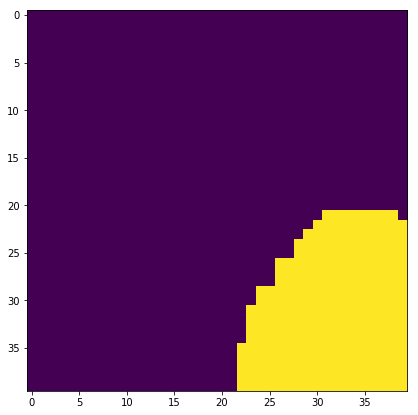

In [352]:
plt.imshow(negSamples[14])

In [338]:
def generateFeature(img):
    m = moments(img)
    
    cr = m[0, 1] / m[0, 0]
    cc = m[1, 0] / m[0, 0]
    
    mu = moments_central(img, cr, cc)
    nu = moments_normalized(mu)
    hu = moments_hu(nu)
    hu[np.isnan(hu)] = 0
    hu[np.isinf(hu)] = 0
    hu = np.concatenate((hu, np.array([np.mean(img)])))
    
    return hu

In [372]:
posFeat = [generateFeature(patch) for patch in posSamples]
negFeat = [generateFeature(patch) for patch in negSamples]

In [375]:
negFeatSelect = [negFeat[ind] for ind in np.random.choice(range(len(negSamples)), size=1000)]

In [376]:
np.shape(negFeatSelect)

(1000, 8)

In [377]:
lables = np.concatenate((np.ones(len(posFeat)), np.zeros(len(negFeatSelect))))
trainData = np.concatenate((np.array(posFeat), np.array(negFeatSelect)))
# svm.SVC()

In [378]:
svmClassifier = svm.SVC()
svmClassifier.fit(trainData, lables)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [379]:
accu = svmClassifier.predict(np.array(trainData))
# svmClassifier.verbose
np.mean(accu == lables)

0.8550204918032787

In [305]:
def findCont(img):
    """
        input: img type: ndarray
        output: complex position of the points on the contour
    """
    contour = cv2.findContours(img, 
                               cv2.RETR_EXTERNAL, 
                               cv2.CHAIN_APPROX_NONE)[0]
    
    contour = max(contour, key=cv2.contourArea)
    plt.scatter(contour[:,:,0], contour[:,:,1])
    plt.imshow(img)
    contRes = contour[:,0,0] + 1j*contour[:,0,1]
    return contRes

In [306]:
def contourFourier(img):
    """
        input: images type: list
                mode: int
        output: Fourier transform of the contour
    """
    u_k = findCont(img)
            
    y_l = np.fft.fft(u_k)
    y_l_shift = np.fft.fftshift(y_l)
    f_descriptor = np.abs(y_l)[1:3]
    
    return f_descriptor

### Moment + SVM

In [484]:
# generate moment
Mpos = [moments_hu(im) for im in imgSamples]
Mneg = [moments_hu(im) for im in imgSampleNeg]

In [724]:
def generateFeature(img):
    mom = cv2.moments(img)
    feat = [mom['mu01'], mom['mu10'], mom['mu20'],
            mom['mu11'], mom['mu02'], mom['mu30'], mom['mu21'],
            mom['mu12'], mom['mu03']]
    return np.array(feat)

In [725]:
Mpos_second = [generateFeature(im) for im in imgSamples]
Mneg_second = [generateFeature(im) for im in imgSampleNeg]

KeyError: 'mu01'

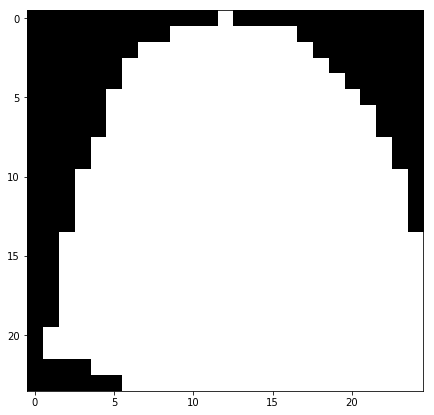

In [711]:
plt.imshow(imgSamples[9], cmap='gray')

In [618]:
print('the shape of positive samples is ', np.shape(Mpos_second))
print('the shape of negative samples is ', np.shape(Mneg_second))

the shape of positive samples is  (7483, 10)
the shape of negative samples is  (8000, 10)


In [619]:
X = np.concatenate((Mpos_second, Mneg_second))
y = np.concatenate((np.ones(np.shape(Mpos_second)[0]), np.zeros(np.shape(Mneg_second)[0])))

In [620]:
#SVM
clf = svm.SVC(gamma='scale', tol=1e-6, probability=True)
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=1e-06, verbose=False)

##### Evaluate of Moment+SVM

In [621]:
# accuracy
acc_pos = np.mean([clf.predict(np.array(M).reshape(1,-1))[0] for M in Mpos_second])
acc_pos

0.7518374983295469

In [622]:
acc_pos = 1 - np.mean([clf.predict(np.array(M).reshape(1,-1))[0] for M in Mneg_second])
acc_pos

0.936625

In [463]:
def IoUperBlock(img, blocks, gtblock, verbose=0):
    """
        Input:
            img: np.darray
            blocks: list of the prediction ground
            gtblock: groundTruth
        return: IoU value
    """
    
    width, height = np.shape(img)

    res = []
    resBlock = []
    for block in blocks:
        imgOri = np.zeros_like(img)
        imggt = np.zeros_like(imgOri)
        
        minr = block[0]
        minc = block[1]
        maxr = min(block[0]+block[2], width)
        maxc = min(block[1]+block[3], height)
        
        imgOri[minr:maxr, minc:maxc] = 1

        imggt[gtblock['bbox'][1]:gtblock['bbox'][1] + gtblock['bbox'][3], gtblock['bbox'][0]:gtblock['bbox'][0] + gtblock['bbox'][2]] = 1

        imgol = imggt + imgOri

        sizeI = np.sum(imgol == 2)
        sizeU = np.sum(imgol == 1) + np.sum(imgol == 2)
        if sizeI > 0:
            if verbose:
                print('IoU is %f' % (sizeI / sizeU))
                plt.imshow(imgol)
                plt.show()
            res.append(sizeI/sizeU)
            resBlock.append(block)
    
    if res:
        return resBlock[np.argmax(res)], np.max(res)
    
    return None, 0.0

In [467]:
def detect_by_method_1(img, blockSize, stepSize, anno):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    Height, Width = np.shape(img)
    # check whether the area has been checked or not (later this can be optimized by using the probability)
    img_record = np.zeros_like(img)
#     patches = []
    img_patches = view_as_windows(arr_in=img, window_shape=(blockSize, blockSize), step=stepSize)
    img_records = {(i, j):img_patches[i,j] for i in range(np.shape(img_patches)[0]) for j in range(np.shape(img_patches)[1])}
    
    print(len(img_records))
    def check(small_patch):
        if svmClassifier.predict(generateFeature(small_patch).reshape(1,-1))[0]:
            return True
        return False
    
    img_filter = list(filter(lambda x: check(x[1]), img_records.items()))
    
    img_positions = [[img_block[0][0]*stepSize, img_block[0][1]*stepSize, blockSize, blockSize] for img_block in img_filter]
    
    fig, ax = plt.subplots(1,1)
    
    
    for img_block in img_filter:
        rect = patches.Rectangle((img_block[0][1]*stepSize, img_block[0][0]*stepSize), blockSize, blockSize,
                linewidth=0.5,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    for an in anno:
        block, iou_val = IoUperBlock(img, img_positions, an)
        if iou_val > 0.3:
            rect = patches.Rectangle((block[1], block[0]), block[3], block[2],
                linewidth=0.5,edgecolor='g',facecolor='none')
            ax.add_patch(rect)
    
    for an in anno:
        rect = patches.Rectangle((an['bbox'][0], an['bbox'][1]), an['bbox'][2], an['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
    #         ax[0].add_patch(rect)
        ax.add_patch(rect)

    ax.imshow(img)
    

    return img_filter

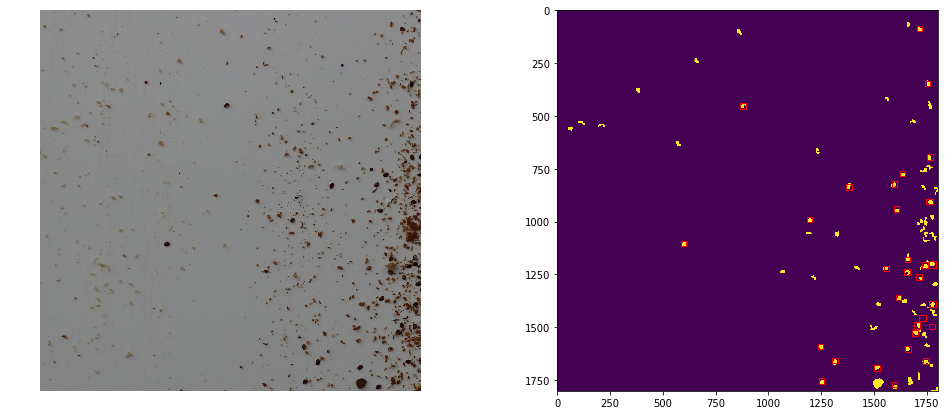

In [468]:
plotAnnoOnImg(image_test[11], annotations_test[11])

2025


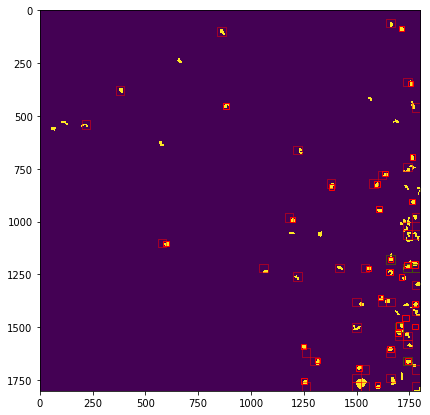

In [469]:
detectedAnno = detect_by_method_1(img=image_test_preprocess[11], blockSize=40, stepSize=40, anno=annotations_test[11])

In [397]:
len(detectedAnno)

457

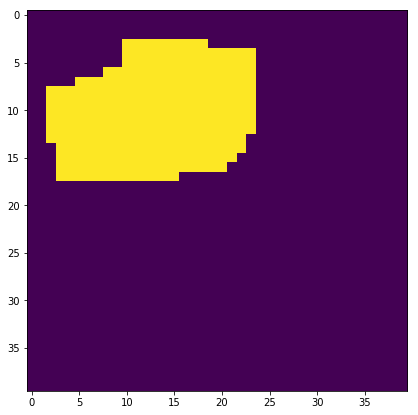

In [384]:
plt.imshow(detectedAnno[3][1])

###### Reflection:
1. very slow:<br>
    a. Reason1: step is 1 which is meaning less <br>
    b. Reason2: can actually skip to next one if the current one is satisfied <br>
    c. Reason3: SVM can be simplier as no big differences whether augmented or not <br>
    d. Reason4: before svm, we can add another checker

In [685]:
img_gray = skimage.color.rgb2grey(image_train[1])

In [680]:
clf.predict(generateFeature(patches_1[6,0]).reshape(1,-1))[0]

1.0

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code